In [1]:
# %pip install salabim

# The Poisson process

In [2]:
import salabim as sim

The Poisson process has exponentially distributed inter-arrival times.
Additionally, the number of arrivals in a time interval of unit length
follows a Poisson distribution with a mean equal to the arrival rate.
In this example, we will simulate a Poisson process with an arrival rate
of 5.0 and plot the distribution of the actual number of arrivals in each
time unit.

In [3]:
lambd = 5.0

# Define a request with a simple process that simply marks the arrival
# and prints a log message every 5000 arrivals
class Request(sim.Component):
    def process(self):
        arrivals.tally(1) # If we had batch arrivals this would be the batch size
        if arrivals.number_of_entries() % 5000 == 0:
            print(arrivals.number_of_entries())

        # All processes must yield, so insert a dummy "yield statement"
        yield self.hold(0)

# Define the simulation environment, using a default random seed of 1234567
env = sim.Environment()

# Define the arrival process as a ComponentGenerator.
generator = sim.ComponentGenerator(Request, iat=sim.Exponential(rate=lambd))

# Define a Monitor to record each arrival event.
arrivals = sim.Monitor(name='arrivals', type='int8')

# Run the simulation for 10 thousand time units and print the final number of arrivals.
# Note Python ignores underscores in numeric values.
env.run(till=10_000)
print(arrivals.number_of_entries())


5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
50213


Count the number of arrivals in each time interval 0..1, 1..2, etc.
In this example, the probabiliy of an event occuring exactly upon an interval boundary is 0.

To use pandas' resample() function, we interpret our timestamps as seconds from 1 Jan 2022.

In [4]:
import pandas as pd

t, x = arrivals.tx()
df = pd.DataFrame(dict(time=t, count=x))

# Convert to seconds from 1 Jan 2022
df.time = pd.to_datetime(df.time, unit='s', origin=pd.Timestamp('2022-01-01'))

df

,time,count
0,2022-01-01 00:00:00.660143360,1
1,2022-01-01 00:00:00.713910784,1
2,2022-01-01 00:00:00.888118528,1
3,2022-01-01 00:00:00.939541248,1
4,2022-01-01 00:00:01.619327488,1
...,...,...
50208,2022-01-01 02:46:37.971096320,1
50209,2022-01-01 02:46:39.030275072,1
50210,2022-01-01 02:46:39.257890816,1
50211,2022-01-01 02:46:39.463158784,1


In [5]:
# Compute number of arrival events in each second
df2 = df.resample('S', on='time').sum()
df2

,count
time,
2022-01-01 00:00:00,4
2022-01-01 00:00:01,4
2022-01-01 00:00:02,4
2022-01-01 00:00:03,2
2022-01-01 00:00:04,7
...,...
2022-01-01 02:46:35,3
2022-01-01 02:46:36,3
2022-01-01 02:46:37,4


In [6]:
counts = df2.loc[:,'count'].to_numpy()

print(counts.__repr__())
print(len(counts))

array([4, 4, 4, ..., 4, 0, 4], dtype=int64)
10000


The following code plots the simulated (empirical) and theoretical probability distributions of the number of arrivals in a time unit.

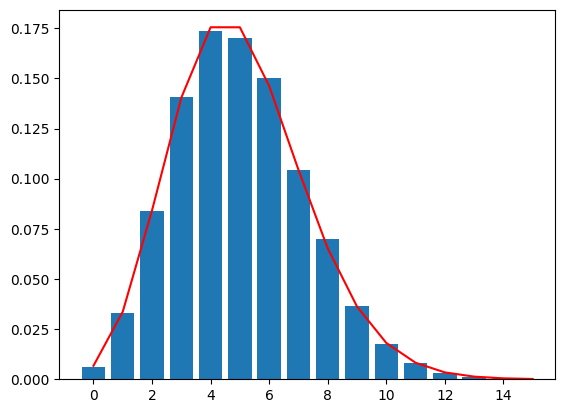

In [7]:
from matplotlib import pyplot as plt
from scipy.stats import poisson
import numpy as np

bins = np.arange(max(counts)+1) # 0 to max(counts) inclusive

# Empirical probability mass function
y, x = np.histogram(counts, bins=bins)
y = y/np.sum(y) # Convert counts to probability mass
plt.bar(x[:-1],y)

# Theoretical probability mass function
theoretical_dist = poisson(lambd)
plt.plot(bins, [theoretical_dist.pmf(n) for n in bins], color='red')

plt.show()